# Single-particle Eigenstate Thermolization in Polariton Hamiltonians. Photonic Wire Model
**Ribeiro Group Rotation Project A**

Brian Zhao, 09 Sept 2022

The following is adapted from Ribeiro, R. F. _Multimode Polariton Effects on Molecular Energy Transport and Spectral Fluctuations_. Commun Chem 2022, 5 (1), 1–10. https://doi.org/10.1038/s42004-022-00660-0.

### Model Hamiltonian
#### Cavity Hamiltonian
The empty cavity Hamiltonian is given by
$$
H_{\text{L}}=\sum_q \epsilon_q a_q^{\dagger}a_q,
$$
where
$$
\epsilon_q = \frac{\hbar c}{\sqrt{\epsilon}}\sqrt{q_0^2+q^2},
$$
where $q_0=\sqrt{(\pi/L_z)^2+(\pi/L_y)^2}$ is a constant, and $q=2\pi m/L$ ($m\in \mathcal{Z}$) are the _cavity modes_.

#### Matter Hamiltonian
The Hamiltonian for the molecules are given by
$$
H_{\text{M}}=\sum_{i=1}^{N_{\text{M}}}(\epsilon_{\text{M}}+\sigma_i)b_i^+b_i^-,
$$
where $b_i^+=|1_i\rangle\langle 0_i|$ and $b_i^-=|0_i\rangle\langle 1_i|$ creates and annihilates an excitation at the $i$-th molecule respectively, and $\sigma_i$ is drawn from a normal distribution with variance $\sigma^2$.

#### Light-matter Hamiltonian
Applying the Coulomb gauge in the rotating-wave approximation (ignoring double raising and lowering), we have
$$
H_{\text{LM}}=\sum_{j=1}^{N_{\text{M}}}\sum_q\frac{-i\Omega_{\text{R}}}{2}\sqrt{\frac{\epsilon_{\text{M}}}{N_{\text{M}}\epsilon_q}}\frac{\mu_j}{\mu_0}\left(e^{iqx_j}b_j^+a_q-e^{-iqx_j}a_q^{\dagger}b_j^- \right),
$$
where $\Omega_{\text{R}}=\mu_0\sqrt{\hbar\omega_0N_{\text{M}}/2\epsilon LL_yL_z}$, and $\mu_j$ is drawn from a normal distribution with variance $\sigma_{\mu}^2$.

We assume there is only one photon.

In [31]:
import numpy as np
import scipy.constants as cst
import matplotlib.pyplot as plt
import pickle
%matplotlib widget

q_to_ev = cst.c*cst.hbar/cst.e

class QuantumWire:
    
    def __init__(self, num_mol, omega_r, a, Ly, Lz, eps, em_mean, em_sigma, mu_sigma, f):

        self.num_mol = num_mol # Number of molecules
        
        # The restriction of N_c == N_m should be removed in future
        try:
            assert (num_mol-1)%2 == 0
        except AssertionError:
            raise ValueError('num_mol needs to be 2N+1, where N is a positive integer!')
            
        self.n = int((num_mol-1)/2) # Number of *distinct* cavity modes
        self.omega_r = omega_r # Rabi splitting / eV
        self.a = a # Molecular spacing / nm
        self.Ly = Ly # y-length / nm
        self.Lz = Lz # z-length / nm
        self.L = num_mol*a # x-legnth /nm
        self.eps = eps # Polarisability
        self.em_mean = em_mean # Mean molecular excitation energy / eV
        self.em_sigma = em_sigma*omega_r # STD of molecular excitation energy / eV
        self.mu_sigma = mu_sigma # STD of ratio of mu_j/mu_0
        self.f = f # Fractional spread of molecular positions
        
        self.rng = np.random.default_rng() # Initialise our random number generator
        
        self.photon_energies = None
        self.mol_energies = None
        self.hamil = None
        self.eigvals = None
        self.eigvecs = None
        self.lp_eigvals = None
        self.up_eigvals = None
        self.lp_photonic_content = None
        self.up_photonic_content = None
        
    def e_q(self, m):
        return np.sqrt((np.pi/self.Lz)**2 + (np.pi/self.Ly)**2 + (2*np.pi*m/self.L)**2) * q_to_ev/np.sqrt(self.eps)

    def generate_hamil(self):
        self.photon_energies = np.array([self.e_q(_) for _ in range(-self.n,self.n+1)])
        self.cavity_modes = np.array([(_,_) for _ in self.photon_energies[self.n+1:]]).flatten()
        self.cavity_modes = np.insert(self.cavity_modes,0,self.photon_energies[self.n])
        self.mol_energies = np.array([self.rng.normal(self.em_mean, self.em_sigma) for _ in range(self.num_mol)])
        
        self.hamil = np.diag(np.concatenate([self.photon_energies,self.mol_energies])) # Fill in the diagonal elements
        self.hamil = self.hamil.astype('complex128')
        
        # Fill in the off-diagonal elements
        # We just fill in the light-matter block (first quadrant), and take the complex conjugate for the third quadrant.
        for j in range(self.num_mol,2*self.num_mol):
            # This is the matter loop, we put it outside so mu_j only needs to be drawn once
            mu_j = self.rng.normal(1, self.mu_sigma)
            for q in range(self.num_mol):
                # omega_q was already computed in _diag
                omega_q = self.photon_energies[q]
                self.hamil[q,j] = (self.omega_r/2)*np.sqrt(self.mol_energies[j-self.num_mol]/(self.num_mol*omega_q))*(mu_j)*np.exp(-((q*2*np.pi/(self.a*self.num_mol))*(self.a*(j-self.num_mol)+self.a*self.rng.uniform(-self.f,self.f))-0.5*np.pi)*1j)
                self.hamil[j,q] = np.conjugate(self.hamil[q,j])
    
    def diag_hamil(self):
        self.eigvals, self.eigvecs = np.linalg.eigh(self.hamil)
        self.lp_eigvals = self.eigvals[:self.num_mol]
        self.up_eigvals = self.eigvals[self.num_mol:]
        photonic_content = np.array([sum(np.conjugate(self.eigvecs[:self.num_mol,_])*self.eigvecs[:self.num_mol,_]) for _ in range(self.num_mol*2)])
        photonic_content = photonic_content.astype('float64')
        self.lp_photonic_content = photonic_content[:self.num_mol]
        self.up_photonic_content = photonic_content[self.num_mol:]
        
    def pickle_wire(self, fname):
        with open(fname, 'bw') as fhandle:
            pickle.dump(self, fhandle)
        
    def plot_eigenstates(self, xlim, ylim):
        f,ax = plt.subplots(figsize=(8,8))
        im = ax.scatter(np.arange(0,self.num_mol), self.lp_eigvals, c=self.lp_photonic_content*100, cmap='magma', vmin=0, vmax=100)
        ax.scatter(np.arange(0,self.num_mol), self.up_eigvals, c=self.up_photonic_content, cmap='magma')
        ax.plot(np.arange(0,self.num_mol), self.cavity_modes, linestyle='--', color='tab:green', lw=1)
        ax.axhline(y=self.em_mean,linestyle='--', color='black', lw=1)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel('Eigenstate index')
        ax.set_ylabel(r'$E$ / eV')

        f.colorbar(im, ax=ax, fraction=0.05, pad=0.04, label='% photonic content')
        
    def plot_molecular_dos(self, num_bins):
        weights,bins = np.histogram(self.lp_eigvals,bins=num_bins)
        bins = (bins[:-1]+bins[1:])/2
        idx = np.cumsum(weights)
        idx = np.insert(idx,0,0)
        ldos = np.array([np.sum(np.conjugate(self.eigvecs[self.num_mol:,_])*self.eigvecs[self.num_mol:,_])/self.num_mol for _ in range(self.num_mol)])

        binned_ldos = np.array([np.sum(ldos[idx[i]:idx[i+1]]) for i in range(len(idx)-1)])
        
        f,ax = plt.subplots(figsize=(8,8))
        ax.bar(bins,binned_ldos,width=(bins[1]-bins[0]))
        
    def refresh_rng(self):
        self.rng = np.random.default_rng()
        
        
def unpickle_wire(fname):
    with open(fname, 'br') as fhandle:
        qw = pickle.load(fhandle)
    
    return qw

def get_r_index(qw, nreal, fname=None, window_width=50, plot=False):
    """
    Gets the r index as defined in eqn. 10 of 10.1016/j.aop.2021.168469. 
    0.5307 is the theoretical GOE result, and Poisson is 0.3863.
    """
    w = np.zeros(nreal)
    for r in range(nreal):
        qw.refresh_rng()
        qw.generate_hamil()
        qw.diag_hamil()
        lvls = qw.lp_eigvals[qw.n-window_width:qw.n+window_width]
        s = lvls[1:]-lvls[:-1]
        ra = np.array([min(s[i],s[i+1])/max(s[i],s[i+1]) for i in range(len(s)-1)])
        w[r] = np.average(ra)

    avg = np.array([np.average(w[:i+1]) for i in range(len(w))])
    err = np.array([avg[i]/np.sqrt((i+1)*window_width*2) for i in range(nreal)])
    
    if fname is not None:
        np.savetxt(f'data/{fname}',avg)
    
    if plot:
        f,ax = plt.subplots(figsize=(8,8))
        ax.errorbar(np.arange(1,21),avg,yerr=err,marker='x')
    
    return avg[-1]

def get_gap_distribution(qw, nreal, num_bins=150, start=50, end=50, hist_range=(0,0.002)):
    nstates = qw.num_mol - start - end
    gaps = np.zeros((nreal,nstates-1))
    
    if end == 0:
        end = None # Make sure negative indexing works for 0, otherwise a[blah:0] returns empty array.
        
    for i in range(nreal):
        qw.generate_hamil()
        qw.diag_hamil()
        gaps[i,:] = qw.lp_eigvals[1+start:-end]-qw.lp_eigvals[start:-end-1]
        qw.refresh_rng()
        
    gaps_new = gaps.flatten()
    weights, bins = np.histogram(gaps_new, bins=num_bins, range=hist_range)
    bins = (bins[:-1]+bins[1:])/2
    f,ax = plt.subplots(figsize=(8,8))
    ax.bar(bins, weights, width=(bins[1]-bins[0]))
    ax.set_xlim(hist_range)


### Basic usage / tutorial
A `QuantumWire` object can be initialised as follows:
```python
qw = QuantumWire(num_mol=1001, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0.1, f=0.05)
```
where the arguments are 
- `num_mol`: Number of molecules. Must be $2N+1$, $N\in\mathcal{Z}^+$. The same number of cavity modes are created, with their quantum numbers $m=-N,-N+1,\dots,0,\dots,N-1,N$
- `omega_r`: The Rabi splitting, in units of eV.
- `a`: The average spacing between molecules, in units of meters.
- `Ly`: The y-length, in units of meters.
- `Lz`: The z-length, in units of meters.
- `eps`: The permittivity.
- `em_mean`: The average molecular excitation energy, in units of eV.
- `em_sigma`: The standard deviation of the excitation energy, in units of the **fraction of** Rabi splitting
- `mu_sigma`: The standard deviation of $\mu_j/\mu_0$, unitless.
- `f`: The range of variation in the position of each molecule as a fraction of `a`, unitless.

The Hamiltonian can be generated and diagonalized by
```python
qw.generate_hamil()
qw.diag_hamil()
```
And the eigenvalues and eigenvectors can be accessed by `qw.eigvals` and `qw.eigvecs` respectively. The lower and upper polariton eigenvalues and photonic contents can be accessed by `qw.(l/u)p_(eigvecs/photonic_content)`.

The lower/upper polariton bands can be plotted, together with their photonic contents:

<ipython-input-10-5e18ab604755>:73: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


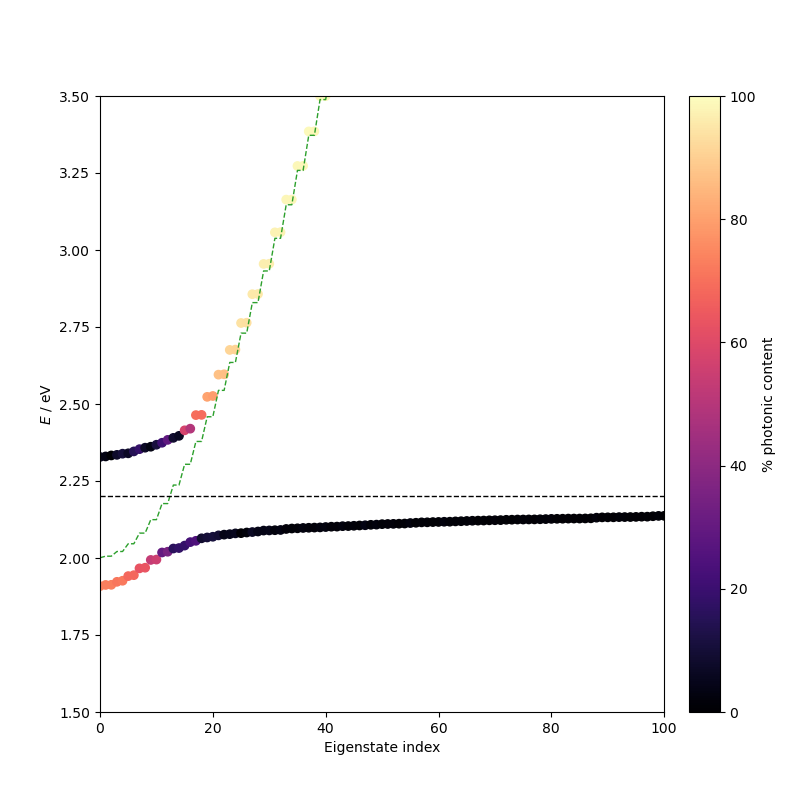

In [12]:
qw = QuantumWire(num_mol=501, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0.1, f=0.05)
qw.generate_hamil()
qw.diag_hamil()
qw.plot_eigenstates([0,100], [1.5,3.5])

And the local molecular density of states can be visualized as follows

<ipython-input-10-5e18ab604755>:73: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


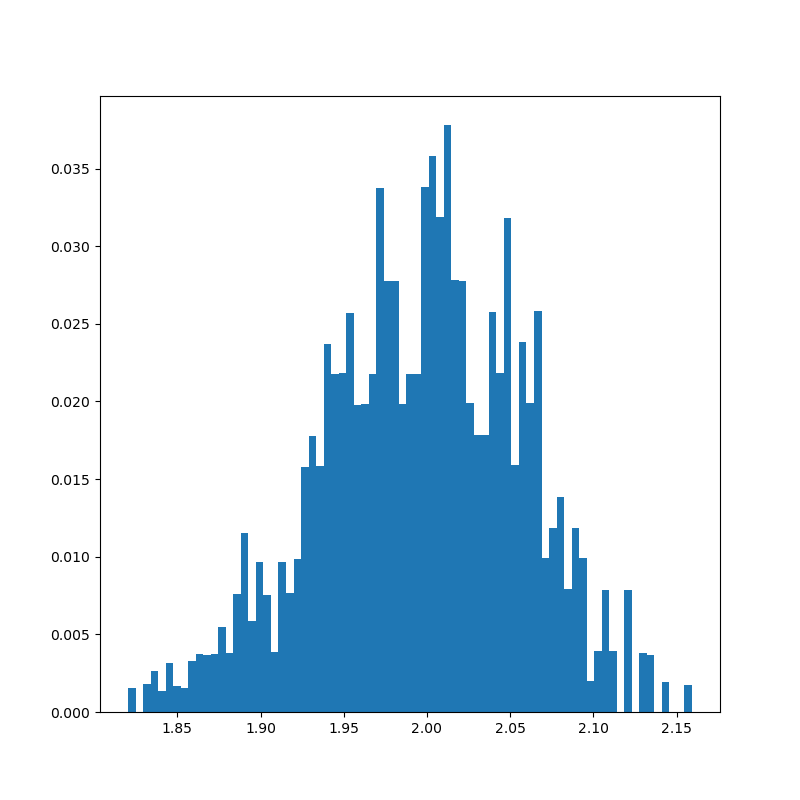

In [14]:
qw = QuantumWire(num_mol=501, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2, em_sigma=0.2, mu_sigma=0.1, f=0.05)
qw.generate_hamil()
qw.diag_hamil()
qw.plot_molecular_dos(75)

The $r$-index, as defined in 10.1016/j.aop.2021.168469, is a good summary metric of whether we have a Poisson-like ($r\approx0.3863$) or Wigner-Dyson-like ($r\approx0.5307$) ensemble. The convenience function ``get_r_index`` can perform this calculation, averaged over a user-defined number of realizations. To get good statistics, we need about 20 realizations: this can be seen by a convergence plot by setting ``plot=True``.

<ipython-input-15-2065f3da0c1b>:73: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


0.3956741373331682


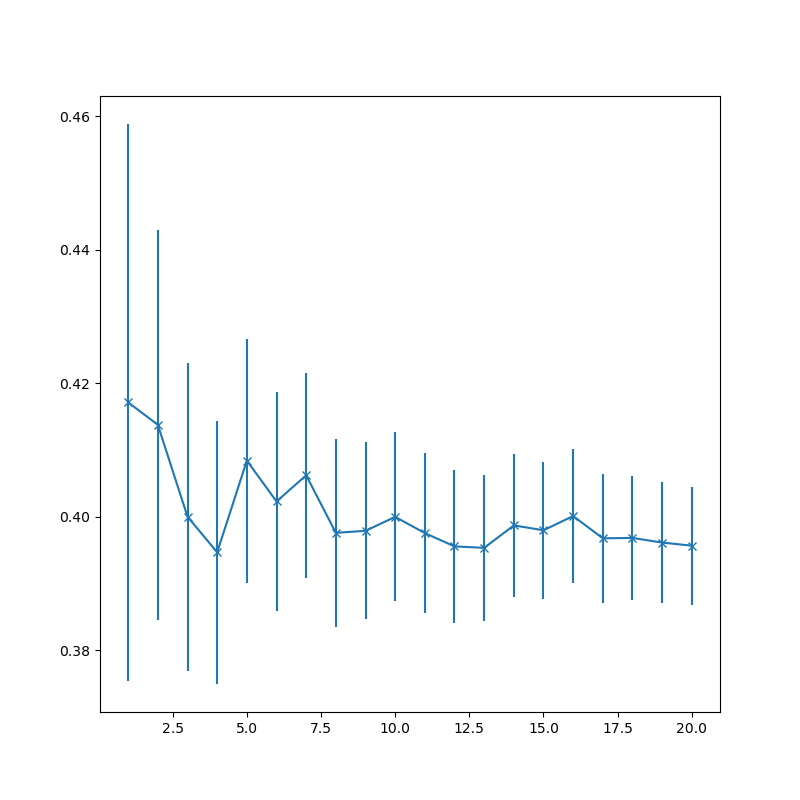

In [18]:
qw = QuantumWire(num_mol=501, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0, f=0)
avg = get_r_index(qw, 20, plot=True)
print(avg)

We can see that we're getting a Poisson-like ensemble, as expected from the zero position and dipole disorders.

<ipython-input-31-13badb8526a1>:73: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


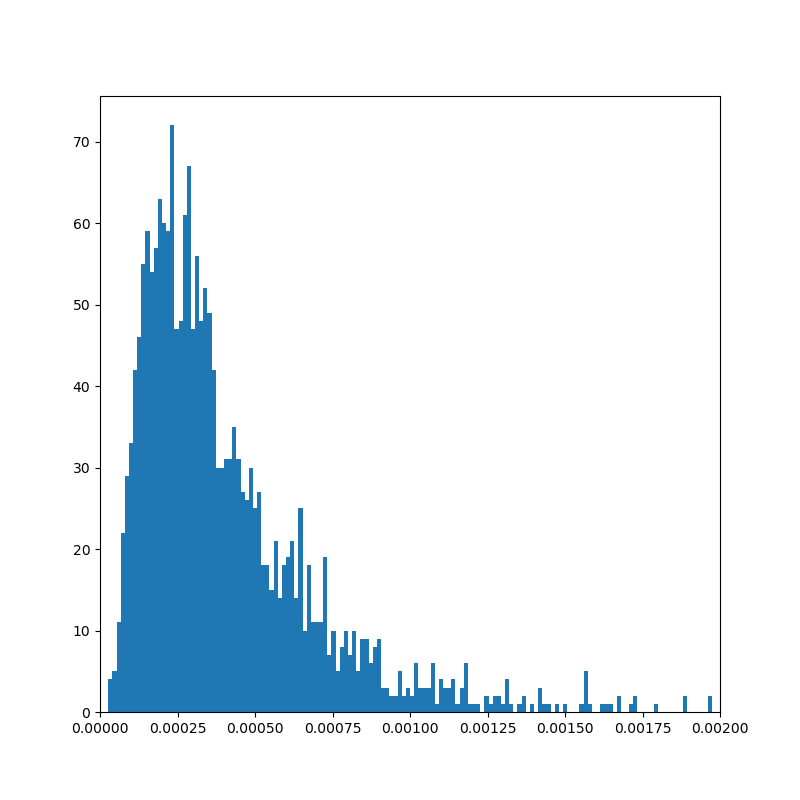

In [32]:
qw = QuantumWire(num_mol=501, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0.1, f=0.1)
get_gap_distribution(qw, nreal=5, num_bins=150, start=50, end=50, hist_range=(0,0.002))

## ---Testing ground below---

In [7]:
# Normalize the gaps by the local average spacings
gaps = a.lp_eigvals[1:]-a.lp_eigvals[:-1]
norm_num_bins = 500
delta_E = (a.lp_eigvals[-1] - a.lp_eigvals[0]) / norm_num_bins
bin_edges = np.array([a.lp_eigvals[0] + delta_E*_ for _ in range(norm_num_bins+1)]) # Includes the rightmost edge
weights, bins = np.histogram(a.lp_eigvals, bin_edges)

In [9]:
weights, bins = np.histogram(a.lp_eigvals, 100)
print(weights)

[ 3  2  2  0  2  0  2  0  2  0  0  2  0  0  2  0  0  2  0  0  1  1  0  1
  0  1  1  1  1  1  0  2  1  1  3  0  3  2  5  2  4  4  1  5  5  5  8 10
 14  7 17 15 20 17 15 17 17 20 22 18 21 24 24 27 30 32 21 29 23 25 24 25
 23 25 19 28 24 24 25 22 18 27 18 21 14 15 18 10  8  9  8  9  6  8  3  9
  5  6  3  4]


In [4]:
a = QuantumWire(num_mol=501, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0.2, f=0.01)
a.generate_hamil()
a.diag_hamil()
print(a.lp_eigvals[a.n-10:a.n+10])


[2.18953648 2.18973168 2.18985288 2.19004305 2.19083448 2.19084661
 2.19161057 2.19180503 2.19217598 2.19262651 2.19288972 2.1929802
 2.19322346 2.19330571 2.19346246 2.19364616 2.19410704 2.19416802
 2.19426418 2.19469404]


<ipython-input-1-3b4fa4e4cf6e>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


In [7]:
r_avg = np.zeros((10,10))
for i,f_i in enumerate(np.linspace(0,0.2,10)):
    for j,ms_j in enumerate(np.linspace(0,0.1,10)):
        a = QuantumWire(num_mol=501, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=ms_j, f=f_i)
        r_avg[i,j] = get_r_index(a, 20, f'501_0.3_2.2_0.2_{ms_j:.2f}_{f_i:.2f}.dat')

np.savetxt('501_0.3_2.2_0.2_0-0.1_0-0.2.dat', r_avg)

<ipython-input-6-3954fefd6acc>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


In [26]:
r_avg = np.zeros(20)
for i,omega_i in enumerate(np.linspace(1e-3,0.2,20)):
    a = QuantumWire(num_mol=501, omega_r=omega_i, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0.05, f=0.1)
    r_avg[i] = get_r_index(a, 20, f'501_0.3_2.2_{omega_i:.3f}_0.05_0.1.dat')

np.savetxt('501_0.3_2.2_1e-3-0.2_0.05_0.1.dat', r_avg)

<ipython-input-6-3954fefd6acc>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


Text(0.5, 1.0, '$r$ index, 20 realizations, $501$ molecules, $E_M=2.2$ eV, $\\sigma_{\\mu}=0.05$, $f$=0.1')

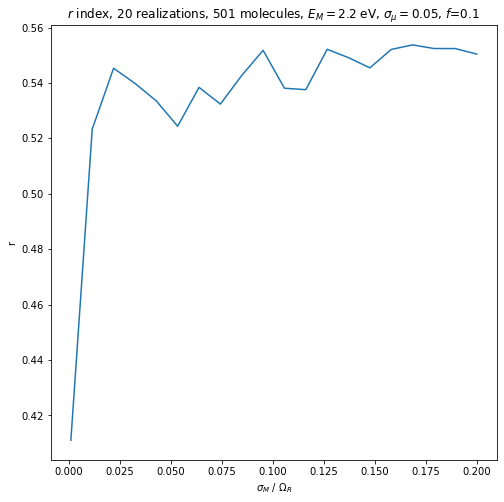

In [30]:
f,ax = plt.subplots(figsize=(8,8))
ax.plot(np.linspace(1e-3,0.2,20),r_avg)
ax.set_xlabel(r'$\sigma_M$ / $\Omega_R$')
ax.set_ylabel(r'r')
ax.set_title(r'$r$ index, 20 realizations, $501$ molecules, $E_M=2.2$ eV, $\sigma_{\mu}=0.05$, $f$=0.1')

In [12]:
r_avg[9,0]

0.5893313454493618

Text(0.5, 1.0, '$r$ index, 20 realizations, $501$ molecules, $E_M=2.2$ eV, $20\\%$ disorder')

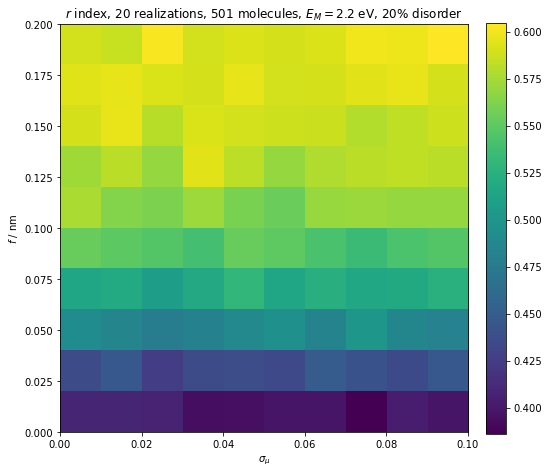

In [25]:
f,ax = plt.subplots(figsize=(8,8))
im = ax.imshow(r_avg,extent=[0,0.1,0.2,0],aspect=0.5)
ax.invert_yaxis()
ax.set_xlabel(r'$\sigma_{\mu}$')
ax.set_ylabel(r'$f$')
f.colorbar(im,ax=ax,fraction=0.046,pad=0.04)
ax.set_title(r'$r$ index, 20 realizations, $501$ molecules, $E_M=2.2$ eV, $20\%$ disorder')

<ipython-input-6-eecdbaa9f510>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


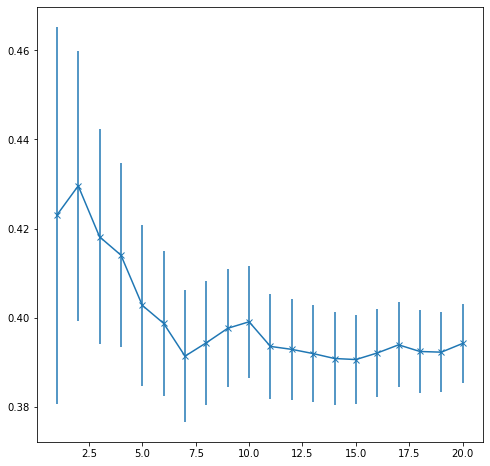

In [16]:
a = QuantumWire(num_mol=1001, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0, f=0)
avg,err = get_r_index(a, 20, '1001_0.3_2.2_0.2_0_0.dat')

<ipython-input-111-fc1a826cf0fd>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


0.5499950526881365
0.611516020734833
0.5980294001694009
0.5771637835084165
0.6162971226432346
0.5472510601877622
0.6152283417037567
0.5719218224680336
0.6349661278040911
0.6134425450171093
0.584040225506407
0.6168126367618457
0.5767991059709338
0.5444472482298663
0.5296248000371419
0.5655056336505003
0.5990061112291925
0.5737974569841134
0.560631254015441
0.5593137589276148


<ErrorbarContainer object of 3 artists>

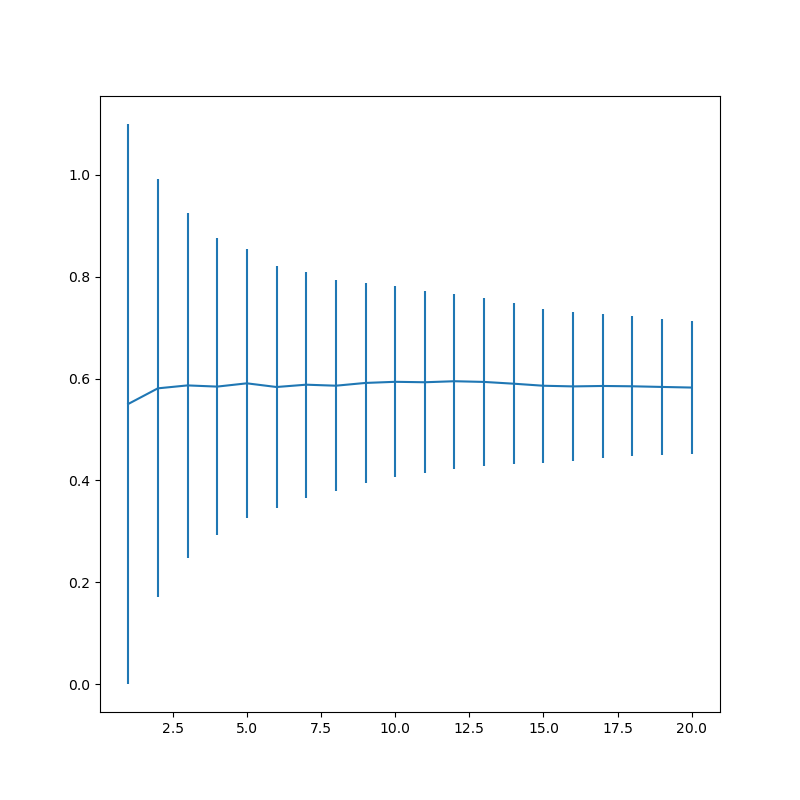

In [134]:
w = np.zeros(20)

for r in range(len(w)):
    a = QuantumWire(num_mol=1001, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0.05, f=0.1)
    a.generate_hamil()
    a.diag_hamil()
    lvls = a.lp_eigvals[a.n-50:a.n+50]
    s = lvls[1:]-lvls[:-1]
    ra = np.array([min(s[i],s[i+1])/max(s[i],s[i+1]) for i in range(len(s)-1)])
    print(np.average(ra))
    w[r] = np.average(ra)
    
avg = np.array([np.average(w[:i+1]) for i in range(len(w))])
err = np.array([avg[i]/np.sqrt((i+1)*50*2) for i in range(len(w))])
f,ax = plt.subplots(figsize=(8,8))
ax.errorbar(np.arange(1,21),avg,yerr=err)

<ipython-input-111-fc1a826cf0fd>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


0.39223887285746456
0.32414162468444774
0.4029327051324375
0.3176445646183939
0.4115809700828961
0.39771896150522745
0.3945975762273518
0.43605576510863797
0.35082208587077585
0.399468634444711
0.38495812131852764
0.3585365920518728
0.3601871521449591
0.4209746080423683
0.37979596704335084
0.4370085760846263
0.43435921216098644
0.38505805473718957
0.39379741253674067
0.37450624261091425


<ErrorbarContainer object of 3 artists>

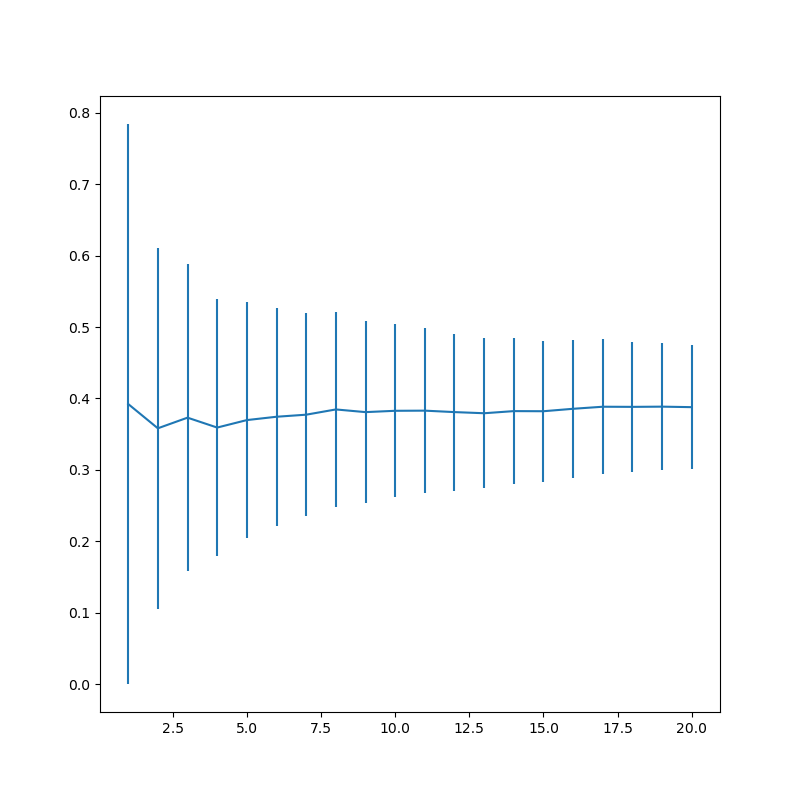

In [136]:
w = np.zeros(20)


for r in range(len(w)):
    a = QuantumWire(num_mol=1001, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=1e-3, mu_sigma=0, f=0)
    a.generate_hamil()
    a.diag_hamil()
    lvls = a.lp_eigvals[a.n-50:a.n+50]
    s = lvls[1:]-lvls[:-1]
    ra = np.array([min(s[i],s[i+1])/max(s[i],s[i+1]) for i in range(len(s)-1)])
    print(np.average(ra))
    w[r] = np.average(ra)
    
avg = np.array([np.average(w[:i+1]) for i in range(len(w))])
err = np.array([avg[i]/np.sqrt(i+1) for i in range(len(w))])
f,ax = plt.subplots(figsize=(8,8))
ax.errorbar(np.arange(1,21),avg,yerr=err)

In [137]:
avg

array([0.39223887, 0.35819025, 0.3731044 , 0.35923944, 0.36970775,
       0.37437628, 0.37726504, 0.38461388, 0.38085924, 0.38272018,
       0.38292363, 0.38089137, 0.37929874, 0.38227559, 0.38211028,
       0.38554142, 0.38841306, 0.38822667, 0.38851987, 0.38781918])

In [127]:
w = np.zeros(20)


for r in range(len(w)):
    a = QuantumWire(num_mol=1001, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2, em_sigma=0.2, mu_sigma=0.05, f=0.1)
    a.generate_hamil()
    a.diag_hamil()
    lvls = a.lp_eigvals[a.n-50:a.n+50]
    s = lvls[1:]-lvls[:-1]
    ra = np.array([min(s[i],s[i+1])/max(s[i],s[i+1]) for i in range(len(s)-1)])
    print(np.average(ra))
    w[r] = np.average(ra)
    
avg = np.array([np.average(w[:i+1]) for i in range(len(w))])
err = np.array([avg[i]/np.sqrt(i+1) for i in range(len(w))])
f,ax = plt.subplots(figsize=(8,8))
ax.errorbar(np.arange(1,21),avg,yerr=err)

<ipython-input-111-fc1a826cf0fd>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


0.583873424429912
0.5736519136167392
0.6027608657064792
0.5864171000004896
0.55002135386908
0.5837717625685802
0.568461739573591
0.5561067408722478
0.544638119566242
0.5660116602948989
0.5620949123057014
0.5973906760284443
0.5531387690889806
0.6010372780764623
0.5771843064191162
0.5883441129620955
0.6495346198233599
0.5497588234082261
0.5442170324935436
0.5590021269368051


<ErrorbarContainer object of 3 artists>

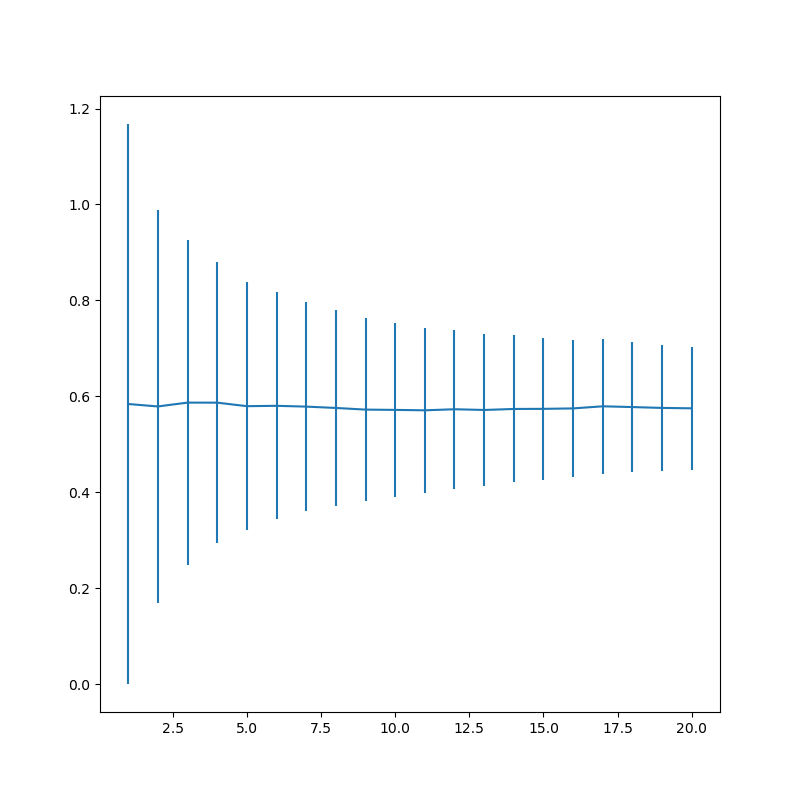

In [132]:
avg = np.array([np.average(w[:i+1]) for i in range(len(w))])
err = np.array([avg[i]/np.sqrt(i+1) for i in range(len(w))])
f,ax = plt.subplots(figsize=(8,8))
ax.errorbar(np.arange(1,21),avg,yerr=err)

In [133]:
print(avg)

[0.58387342 0.57876267 0.58676207 0.58667583 0.57934493 0.58008274
 0.57842259 0.57563311 0.57218922 0.57157147 0.57070996 0.57293336
 0.5714107  0.57352688 0.57377071 0.57468155 0.57908467 0.57745545
 0.57570606 0.57487087]


In [125]:
lvls = a.lp_eigvals[a.n-50:a.n+50]
s = lvls[1:]-lvls[:-1]
ra = np.array([min(s[i],s[i+1])/max(s[i],s[i+1]) for i in range(len(s)-1)])
print(np.average(ra))

0.5913497127307124


In [18]:
a = QuantumWire(num_mol=1001, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0.05, f=0.1)

In [19]:
a.generate_hamil()
a.diag_hamil()
a.pickle_wire('1001_2.2_1.pcl')

<ipython-input-17-b059d1240e93>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


In [22]:
a = unpickle_wire('1001_2.2_1.pcl')

In [96]:
ldos = np.array([np.sum(np.conjugate(a.eigvecs[a.num_mol:,_])*a.eigvecs[a.num_mol:,_])/a.num_mol for _ in range(a.num_mol)])
ldos = ldos.astype('float64')

<ipython-input-96-8f45773548b9>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  ldos = ldos.astype('float64')


In [101]:
weights,bins = np.histogram(a.lp_eigvals,bins=100)
idx = np.cumsum(weights)
idx = np.insert(idx,0,0)
binned_ldos = np.array([np.sum(ldos[idx[i]:idx[i+1]]) for i in range(len(idx)-1)])

[0.00078759 0.00052268 0.00053984 0.0002821  0.00027685 0.00029703
 0.00029492 0.         0.00062848 0.         0.         0.0006779
 0.         0.00037634 0.00036753 0.         0.00041575 0.00040642
 0.         0.         0.00094123 0.         0.         0.00120818
 0.         0.00071295 0.00069438 0.00064973 0.00079619 0.00155836
 0.00088538 0.00087178 0.00156693 0.00169751 0.00176393 0.00277686
 0.0037842  0.00187968 0.00669375 0.00282372 0.00371113 0.00480388
 0.0058384  0.00672729 0.00780203 0.00584204 0.00878173 0.00977195
 0.01181802 0.01082038 0.00984108 0.01379322 0.01679454 0.01782599
 0.01484765 0.01980376 0.01876107 0.01781064 0.01881147 0.01783515
 0.02580061 0.02188037 0.02879502 0.02583173 0.02383375 0.02581444
 0.02679725 0.02979343 0.02185415 0.02781817 0.02785066 0.02681625
 0.02584052 0.02485052 0.02188185 0.03078234 0.01888733 0.02084944
 0.01877742 0.01579937 0.01878237 0.01983811 0.01486986 0.01582155
 0.01481543 0.01383158 0.01377437 0.00980013 0.01177856 0.00977

In [103]:
len(bins)

101

<BarContainer object of 100 artists>

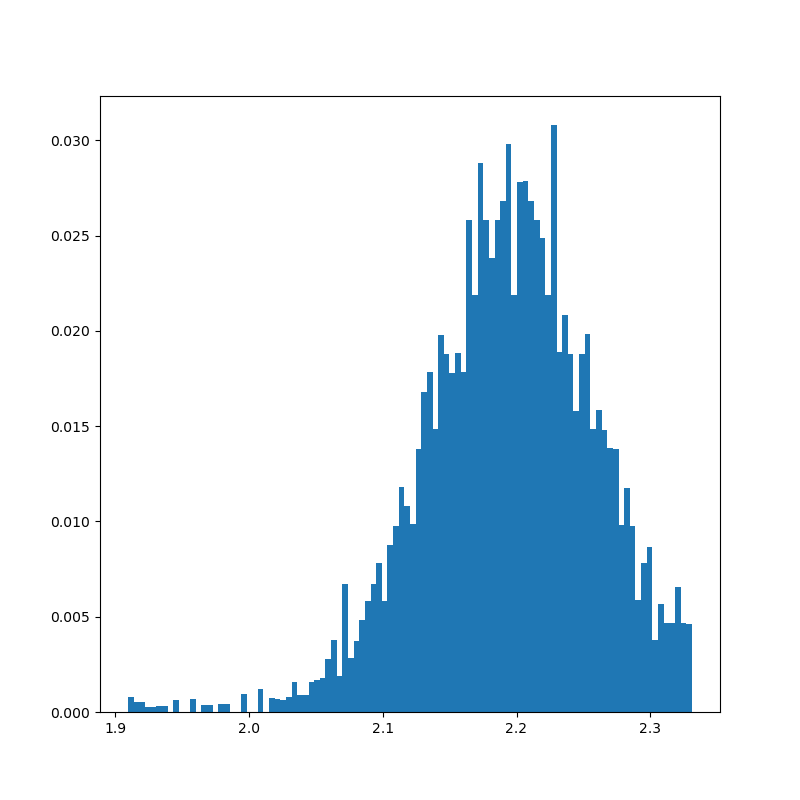

In [104]:
f,ax = plt.subplots(figsize=(8,8))
bins = (bins[:-1]+bins[1:])/2
ax.bar(bins,binned_ldos,width=(bins[1]-bins[0]))

(0.0, 100.0)

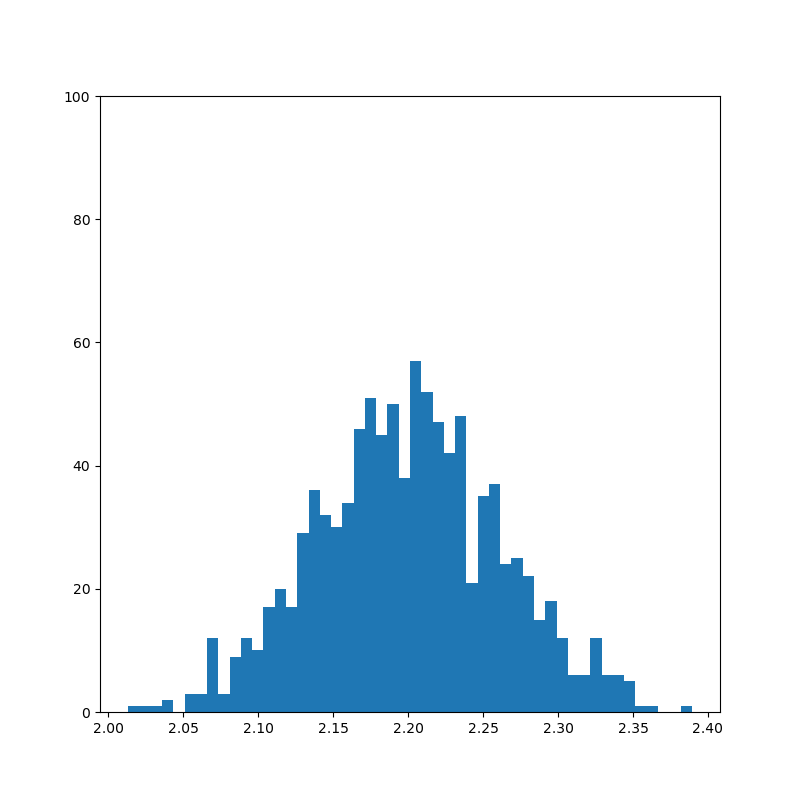

In [39]:
weights, bins = np.histogram(a.mol_energies,50)
bins = (bins[:-1]+bins[1:])/2
f,ax = plt.subplots(figsize=(8,8))
ax.bar(bins,weights,width=(bins[1]-bins[0]))
ax.set_ylim([0,100])

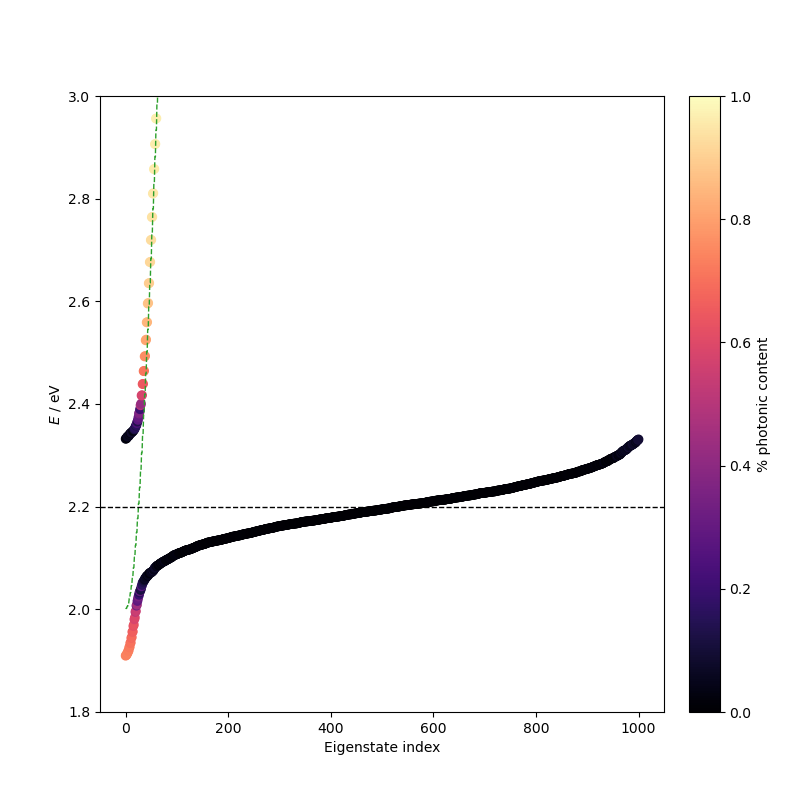

In [53]:
%matplotlib widget
a.plot_eigenstates(None,[1.8,3])

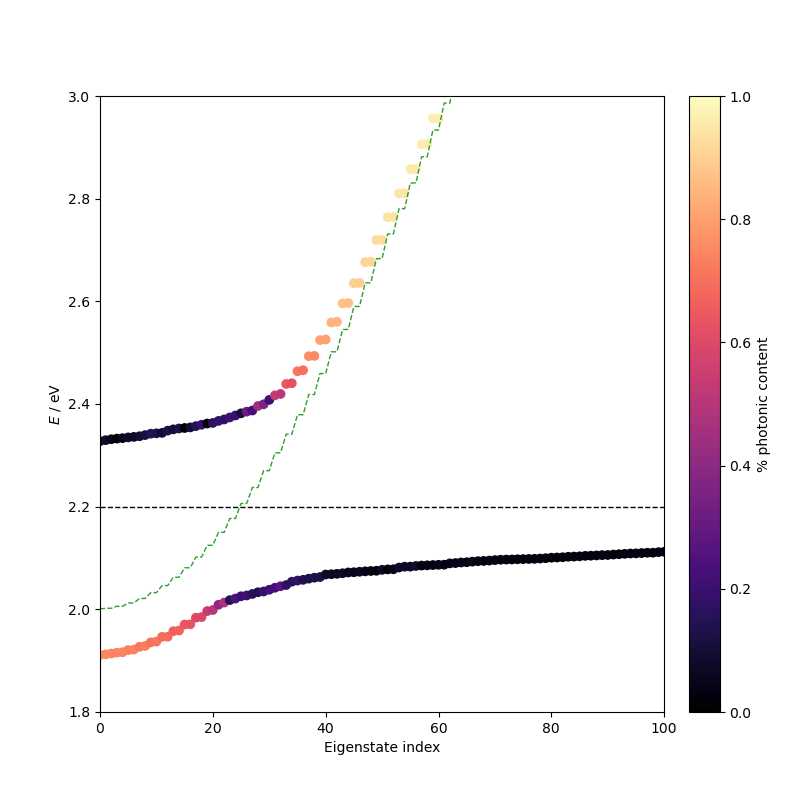

In [9]:
%matplotlib widget
f,ax = plt.subplots(figsize=(8,8))
im = ax.scatter(np.arange(0,1001),a.lp_eigvals[:],c=a.lp_photonic_content,cmap='magma',vmin=0,vmax=1)
ax.scatter(np.arange(0,1001),a.up_eigvals[:],c=a.up_photonic_content,cmap='magma')
ax.plot(np.arange(0,1001),a.cavity_modes,linestyle='--',color='tab:green',lw=1)
ax.axhline(y=a.em_mean,linestyle='--',color='black',lw=1)
ax.set_xlim([0,100])
ax.set_ylim([1.8,3])
ax.set_xlabel('Eigenstate index')
ax.set_ylabel(r'$E$ / eV')

f.colorbar(im, ax=ax, fraction=0.05, pad=0.04, label='% photonic content')

In [ ]:
%matplotlib widget
a = QuantumWire(num_mol=1001, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0.1, f=0.05)
a.generate_hamil()
a.diag_hamil()
gaps[i,:] = a.lp_eigvals[1+edge:]-a.lp_eigvals[+edge:-1]
weights, bins = np.histogram(gaps_new, bins=150, range=(0,0.002))
bins = (bins[:-1]+bins[1:])/2
f,ax = plt.subplots(figsize=(8,8))
ax.bar(bins, weights, width=(bins[1]-bins[0]))
ax.set_xlim([0,0.002])

In [2]:
nreal = 10
edge = 50
gaps = np.zeros((nreal,1001-edge-1))
a = QuantumWire(num_mol=1001, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0.1, f=0.05)
for i in range(nreal):
    a.generate_hamil()
    a.diag_hamil()
    gaps[i,:] = a.lp_eigvals[1+edge:]-a.lp_eigvals[+edge:-1]
    a.refresh_rng()



<ipython-input-1-2b79885834e5>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


(0.0, 0.002)

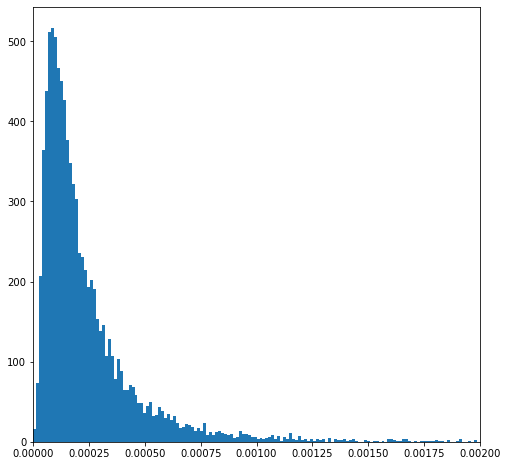

In [3]:
gaps_new = gaps.reshape((nreal,1001-edge-1))[:,50:]
gaps_new = gaps_new.flatten()
weights, bins = np.histogram(gaps_new, bins=150, range=(0,0.002))
bins = (bins[:-1]+bins[1:])/2
f,ax = plt.subplots(figsize=(8,8))
ax.bar(bins, weights, width=(bins[1]-bins[0]))
ax.set_xlim([0,0.002])

In [12]:
nreal = 10
edge = 50
gaps = np.zeros((nreal,1001-edge-1))
a = QuantumWire(num_mol=1001, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0.1, f=0)
for i in range(nreal):
    a.generate_hamil()
    a.diag_hamil()
    gaps[i,:] = a.lp_eigvals[1+edge:]-a.lp_eigvals[+edge:-1]
    a.refresh_rng()

<ipython-input-1-2b79885834e5>:72: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


(0.0, 0.002)

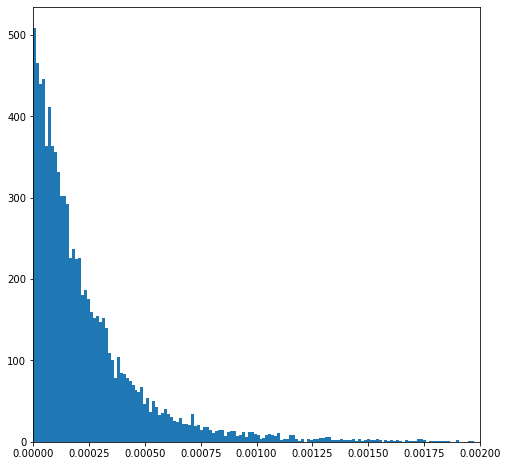

In [13]:
gaps_new = gaps.reshape((nreal,1001-edge-1))[:,50:]
gaps_new = gaps_new.flatten()
weights, bins = np.histogram(gaps_new, bins=150, range=(0,0.002))
bins = (bins[:-1]+bins[1:])/2
f,ax = plt.subplots(figsize=(8,8))
ax.bar(bins, weights, width=(bins[1]-bins[0]))
ax.set_xlim([0,0.002])

(0.0, 0.002)

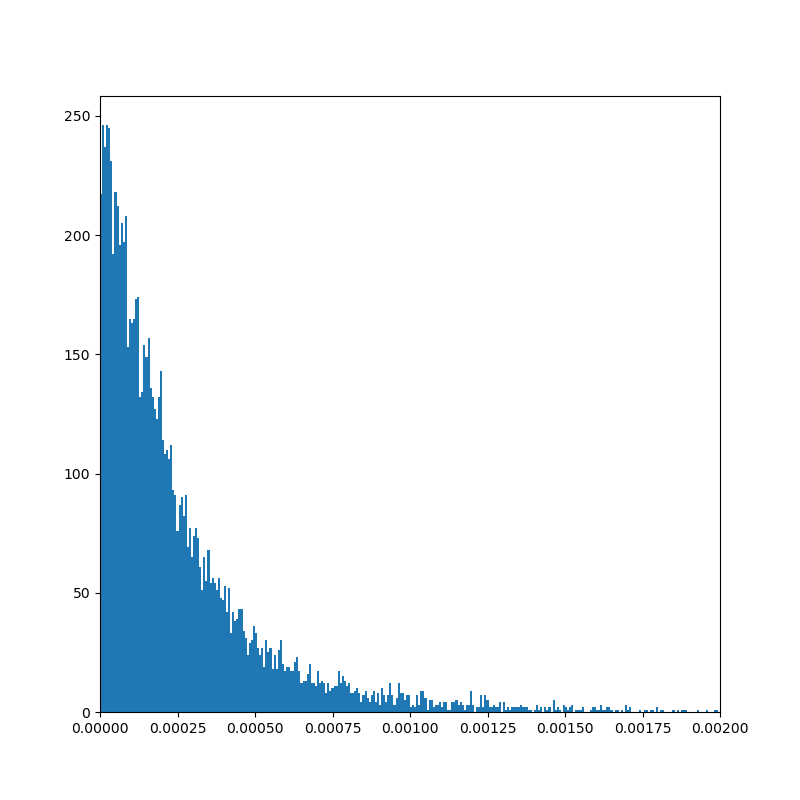

In [34]:
%matplotlib widget
gaps = gaps.flatten()
weights, bins = np.histogram(gaps, bins=300, range=(0,0.002))
bins = (bins[:-1]+bins[1:])/2
f,ax = plt.subplots(figsize=(8,8))
ax.bar(bins, weights, width=(bins[1]-bins[0]))
ax.set_xlim([0,0.002])